In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from binance_data_loader import BinanceDataLoader
from tqdm import tqdm
import scipy.stats

# Information Discreteness calculation function (extracted from binance_simple_id_momentum_strategy.py)
def calculate_id_score(prices, discreteness_window=14):
    """Calculate Information Discreteness score for a price series."""
    if len(prices) < discreteness_window:
        return np.nan
    
    recent_prices = prices[-discreteness_window:]
    
    # Calculate PRET (cumulative return over discreteness_window)
    pret = (recent_prices[-1] / recent_prices[0] - 1) if recent_prices[0] != 0 else 0
    
    # Calculate daily returns within discreteness window
    daily_rets = np.diff(recent_prices) / recent_prices[:-1]
    daily_rets = daily_rets[~np.isnan(daily_rets)]
    
    if len(daily_rets) == 0:
        return np.nan
    
    # Calculate percentage of negative and positive days
    pct_negative = np.sum(daily_rets < 0) / len(daily_rets)
    pct_positive = np.sum(daily_rets > 0) / len(daily_rets)
    
    # ID = sign(PRET) × (% days negative – % days positive)
    sign_pret = 1 if pret > 0 else (-1 if pret < 0 else 0)
    id_score = sign_pret * (pct_negative - pct_positive)
    return id_score

def calculate_combined_score(id_score, momentum_score):
    """Calculate combined ID and momentum score."""
    # Transform ID: use negative(ID) so smallest ID becomes biggest score
    transformed_id = -id_score
    # Combined score: Transformed_ID × Momentum
    return transformed_id * momentum_score

# Raw CV calculation function (extracted from binance_raw_cv_momentum_strategy.py)
def calculate_raw_cv_score(prices, cv_window=14):
    """Calculate Raw Coefficient of Variation score for a price series."""
    if len(prices) < cv_window:
        return np.nan
    
    recent_prices = prices[-cv_window:]
    
    # Calculate absolute price changes over CV window
    price_changes = []
    for i in range(1, len(recent_prices)):
        if recent_prices[i-1] > 0:
            abs_change = abs((recent_prices[i] / recent_prices[i-1]) - 1.0)
            price_changes.append(abs_change)
    
    if len(price_changes) < int(cv_window * 0.6):  # Need 60% valid data
        return np.nan
    
    # Calculate CV = std(price_changes) / mean(price_changes)
    mean_change = np.mean(price_changes)
    std_change = np.std(price_changes)
    
    if mean_change > 0:
        cv = std_change / mean_change  # Raw CV
        return cv
    else:
        return np.nan

def calculate_cv_momentum_combined_score(cv_score, momentum_score):
    """Calculate combined Raw CV and momentum score."""
    # Combined Signal = CV * momentum (lower CV + positive momentum = better)
    # This rewards assets with both positive momentum and low CV (consistent momentum)
    return cv_score * momentum_score

# === IC ANALYSIS FUNCTIONS ===
def calculate_ic(signals, future_returns):
    """Calculate Information Coefficient (Spearman rank correlation)"""
    valid_mask = ~(pd.isna(signals) | pd.isna(future_returns))
    clean_signals = signals[valid_mask]
    clean_returns = future_returns[valid_mask]
    
    if len(clean_signals) < 10:  # Need minimum cross-section
        return np.nan
    
    return scipy.stats.spearmanr(clean_signals, clean_returns)[0]

def calculate_signal_analysis_metrics(ic_series):
    """Calculate signal quality metrics from IC time series"""
    ic_clean = ic_series.dropna()
    if len(ic_clean) == 0:
        return {'mean_ic': np.nan, 'ic_std': np.nan, 'ic_sharpe': np.nan, 'hit_rate': np.nan, 'abs_ic': np.nan, 'ic_count': 0}
    
    return {
        'mean_ic': ic_clean.mean(),
        'ic_std': ic_clean.std(),
        'ic_sharpe': ic_clean.mean() / ic_clean.std() if ic_clean.std() > 0 else 0,
        'hit_rate': (ic_clean > 0).mean(),
        'abs_ic': ic_clean.abs().mean(),
        'ic_count': len(ic_clean)
    }

In [2]:
data_loader = BinanceDataLoader(
    data_directory=r"C:\Users\USER\Documents\Binance_related\dailytickerdata2020",
    min_records=30,
    min_volume=1e5,
    start_date="2022-01-01",
    end_date=None
)

Loading Binance data from C:\Users\USER\Documents\Binance_related\dailytickerdata2020...
Found 534 USDT trading pairs
✓ BTCUSDT loaded successfully with 1353 records, avg volume: 352,340
Loaded 506 cryptocurrencies
Filtered 26 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix for 506 tickers over 1353 dates...
Precomputed returns matrix shape: (1353, 506)
Date range: 2022-01-01 00:00:00 to 2025-09-14 00:00:00


In [3]:
price = data_loader.get_price_matrix()
price

,1000000BOBUSDT,1000000MOGUSDT,1000BONKUSDT,1000CATUSDT,1000CHEEMSUSDT,1000FLOKIUSDT,1000LUNCUSDT,1000PEPEUSDT,1000RATSUSDT,1000SATSUSDT,...,ZEREBROUSDT,ZETAUSDT,ZILUSDT,ZKJUSDT,ZKUSDT,ZORAUSDT,ZRCUSDT,ZROUSDT,ZRXUSDT,1INCHUSDT
2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.07662,NaN,NaN,NaN,NaN,NaN,0.8735,2.5321
2022-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.07707,NaN,NaN,NaN,NaN,NaN,0.8884,2.5527
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.07439,NaN,NaN,NaN,NaN,NaN,0.9405,2.5618
2022-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.07110,NaN,NaN,NaN,NaN,NaN,0.8894,2.4750
2022-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.06663,NaN,NaN,NaN,NaN,NaN,0.8260,2.3191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-10,0.05231,0.9042,0.023194,0.007833,0.001190,0.09738,0.06069,0.010526,0.02093,0.000042,...,0.02184,0.1891,0.01176,0.1759,0.06098,0.06484,0.02654,2.0164,0.2796,0.2597
2025-09-11,0.05546,0.9548,0.024450,0.007883,0.001208,0.10004,0.06085,0.010691,0.02158,0.000041,...,0.02156,0.1896,0.01188,0.1767,0.06127,0.06288,0.02682,2.0317,0.2786,0.2665
2025-09-12,0.05672,1.0150,0.025666,0.008323,0.001236,0.10470,0.06136,0.011540,0.02228,0.000042,...,0.02330,0.1958,0.01209,0.1783,0.06287,0.06541,0.02757,2.0290,0.2772,0.2721
2025-09-13,0.05767,1.0491,0.026078,0.008457,0.001267,0.10686,0.06198,0.011914,0.02206,0.000043,...,0.02455,0.1973,0.01229,0.1860,0.06285,0.06566,0.02748,2.0804,0.2848,0.2736


In [4]:
# Strategy Parameters
n = 14  # Momentum window (days)
k = 10  # Number of coins to go long/short
n_universe = 50  # Top N volume universe to select from each day
vol_window = 30  # Volatility window for inverse vol strategies
discreteness_window = 14  # ID calculation window
cv_window = 14  # Raw CV calculation window
holding_period = 1  # HOLDING PERIOD: Rebalance every N days

# Calculate momentum returns (14-day)
rets = price.pct_change(n)

print(f"Strategy Parameters:")
print(f"- Momentum window: {n} days")
print(f"- Positions: {k} long, {k} short")
print(f"- Universe: Top {n_universe} by 20-day volume")
print(f"- ID window: {discreteness_window} days")
print(f"- CV window: {cv_window} days")
print(f"- Volatility window: {vol_window} days")
print(f"- Holding period: {holding_period} days (rebalance frequency)")
print(f"- Transaction costs: 5bps per trade")
print(f"\nNow comparing 6 different strategies:")
print(f"1. Inverse Vol Momentum (original)")
print(f"2. Pure Momentum (equal weights)")
print(f"3. Simple ID (equal weights)")
print(f"4. Inverse Vol Simple ID")
print(f"5. Raw CV (equal weights)")
print(f"6. Inverse Vol Raw CV")

Strategy Parameters:
- Momentum window: 14 days
- Positions: 10 long, 10 short
- Universe: Top 50 by 20-day volume
- ID window: 14 days
- CV window: 14 days
- Volatility window: 30 days
- Holding period: 1 days (rebalance frequency)
- Transaction costs: 5bps per trade

Now comparing 6 different strategies:
1. Inverse Vol Momentum (original)
2. Pure Momentum (equal weights)
3. Simple ID (equal weights)
4. Inverse Vol Simple ID
5. Raw CV (equal weights)
6. Inverse Vol Raw CV


C:\Users\USER\AppData\Local\Temp\ipykernel_28656\2081123024.py:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = price.pct_change(n)


In [5]:
# Get volume data for universe selection with 20-day rolling average
volume_data = {}
for ticker in data_loader.get_universe():
    ticker_data = data_loader._crypto_universe[ticker]['data']
    volume_data[ticker] = ticker_data['volume'].reindex(price.index)

volume_matrix = pd.DataFrame(volume_data, index=price.index)

# Calculate 20-day rolling average volume
rolling_volume_matrix = volume_matrix.rolling(window=20, min_periods=10).mean()

# Calculate rolling volatility for weighting (using 30-day window)
volatility = price.pct_change().rolling(vol_window).std()

# Calculate BTC 90-day total return for market filter
btc_90d_return = price["BTCUSDT"].pct_change(90)

print("Calculated common data matrices:")
print(f"- Volume matrix: {volume_matrix.shape}")
print(f"- Volatility matrix: {volatility.shape}")
print(f"- Price matrix: {price.shape}")
print(f"- Returns matrix: {rets.shape}")

def run_strategy_1_inverse_vol_momentum():
    """Strategy 1: Inverse Volatility Momentum (Original)"""
    equity = [1.0]
    current_weights = {}  # Current portfolio weights
    last_rebalance_day = -1  # Track last rebalance
    
    for i in range(n, len(price)-1):
        current_date = price.index[i]
        
        # Check if it's time to rebalance (every holding_period days)
        if i - last_rebalance_day >= holding_period:
            # BTC Market Filter: Skip trading if BTC 90-day return is negative
            if not pd.isna(btc_90d_return.iloc[i]) and btc_90d_return.iloc[i] < 0:
                current_weights = {}  # Hold cash during crypto bear markets
            else:
                # Get 20-day rolling average volume for current date
                current_volumes = rolling_volume_matrix.iloc[i].dropna()
                
                # Skip if no volume data available
                if len(current_volumes) == 0:
                    current_weights = {}
                else:
                    # Select top N_universe by 20-day rolling volume for this day
                    top_volume_tickers = current_volumes.nlargest(n_universe).index
                    
                    # Get momentum returns for the volume-filtered universe
                    row = rets.iloc[i]
                    filtered_returns = row[top_volume_tickers].dropna()
                    
                    # Skip if no valid returns in the volume universe
                    if len(filtered_returns) == 0:
                        current_weights = {}
                    else:
                        # Simple momentum ranking: top performers go long, bottom performers go short
                        long_coins = filtered_returns.nlargest(k).index   # top k momentum
                        short_coins = filtered_returns.nsmallest(k).index # bottom k momentum

                        # Calculate inverse volatility weights
                        long_vols = volatility.iloc[i][long_coins]
                        short_vols = volatility.iloc[i][short_coins]
                        
                        # Remove coins with NaN volatility
                        long_valid = long_vols.dropna()
                        short_valid = short_vols.dropna()
                        
                        if len(long_valid) == 0 or len(short_valid) == 0:
                            current_weights = {}
                        else:
                            # Inverse volatility weights (higher weight for lower vol)
                            long_weights = 1 / long_valid
                            short_weights = 1 / short_valid
                            
                            # Normalize so each side sums to 0.5 (equal long/short exposure)
                            long_weights = long_weights / long_weights.sum() * 0.5
                            short_weights = short_weights / short_weights.sum() * 0.5

                            # Store new weights
                            current_weights = {}
                            for coin in long_weights.index:
                                current_weights[coin] = long_weights[coin]
                            for coin in short_weights.index:
                                current_weights[coin] = -short_weights[coin]  # Negative for short
            
            last_rebalance_day = i

        # Calculate daily returns using current weights
        portfolio_return = 0
        
        for coin, weight in current_weights.items():
            p0 = price[coin].iat[i]
            p1 = price[coin].iat[i+1]
            if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                coin_return = (p1 - p0) / p0
                portfolio_return += weight * coin_return

        # Apply transaction costs only on rebalance days
        if i == last_rebalance_day and len(current_weights) > 0:
            portfolio_return -= 0.0005  # 5bps fees
        
        equity.append(equity[-1] * (1 + portfolio_return))
    
    return pd.Series(equity, index=price.index[:len(equity)])

def run_strategy_2_pure_momentum():
    """Strategy 2: Pure Momentum (Equal Weights)"""
    equity = [1.0]
    current_weights = {}  # Current portfolio weights
    last_rebalance_day = -1  # Track last rebalance
    
    for i in range(n, len(price)-1):
        current_date = price.index[i]
        
        # Check if it's time to rebalance (every holding_period days)
        if i - last_rebalance_day >= holding_period:
            # BTC Market Filter: Skip trading if BTC 90-day return is negative
            if not pd.isna(btc_90d_return.iloc[i]) and btc_90d_return.iloc[i] < 0:
                current_weights = {}  # Hold cash during crypto bear markets
            else:
                # Get 20-day rolling average volume for current date
                current_volumes = rolling_volume_matrix.iloc[i].dropna()
                
                # Skip if no volume data available
                if len(current_volumes) == 0:
                    current_weights = {}
                else:
                    # Select top N_universe by 20-day rolling volume for this day
                    top_volume_tickers = current_volumes.nlargest(n_universe).index
                    
                    # Get momentum returns for the volume-filtered universe
                    row = rets.iloc[i]
                    filtered_returns = row[top_volume_tickers].dropna()
                    
                    # Skip if no valid returns in the volume universe
                    if len(filtered_returns) == 0:
                        current_weights = {}
                    else:
                        # Simple momentum ranking: top performers go long, bottom performers go short
                        long_coins = filtered_returns.nlargest(k).index   # top k momentum
                        short_coins = filtered_returns.nsmallest(k).index # bottom k momentum

                        # Equal weights (no volatility adjustment)
                        long_weight = 0.5 / len(long_coins) if len(long_coins) > 0 else 0
                        short_weight = 0.5 / len(short_coins) if len(short_coins) > 0 else 0

                        # Store new weights
                        current_weights = {}
                        for coin in long_coins:
                            current_weights[coin] = long_weight
                        for coin in short_coins:
                            current_weights[coin] = -short_weight  # Negative for short
            
            last_rebalance_day = i

        # Calculate daily returns using current weights
        portfolio_return = 0
        
        for coin, weight in current_weights.items():
            p0 = price[coin].iat[i]
            p1 = price[coin].iat[i+1]
            if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                coin_return = (p1 - p0) / p0
                portfolio_return += weight * coin_return

        # Apply transaction costs only on rebalance days
        if i == last_rebalance_day and len(current_weights) > 0:
            portfolio_return -= 0.0005  # 5bps fees
        
        equity.append(equity[-1] * (1 + portfolio_return))
    
    return pd.Series(equity, index=price.index[:len(equity)])

print("Strategy functions defined with proper holding period logic...")

C:\Users\USER\AppData\Local\Temp\ipykernel_28656\1720481593.py:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  volatility = price.pct_change().rolling(vol_window).std()


Calculated common data matrices:
- Volume matrix: (1353, 506)
- Volatility matrix: (1353, 506)
- Price matrix: (1353, 506)
- Returns matrix: (1353, 506)
Strategy functions defined with proper holding period logic...


In [6]:
def run_strategy_3_simple_id():
    """Strategy 3: Simple ID (Equal Weights) - No volume filtering"""
    equity = [1.0]
    current_weights = {}  # Current portfolio weights
    last_rebalance_day = -1  # Track last rebalance
    
    for i in range(max(n, discreteness_window), len(price)-1):
        current_date = price.index[i]
        
        # Check if it's time to rebalance (every holding_period days)
        if i - last_rebalance_day >= holding_period:
            # BTC Market Filter: Skip trading if BTC 90-day return is negative
            if not pd.isna(btc_90d_return.iloc[i]) and btc_90d_return.iloc[i] < 0:
                current_weights = {}  # Hold cash during crypto bear markets
            else:
                # Use ALL available tickers (no volume filtering for Simple ID)
                all_tickers = price.columns
                
                # Calculate ID and momentum scores for each asset
                combined_scores = {}
                
                for ticker in all_tickers:
                    # Get price history for this ticker up to current date
                    ticker_prices = price[ticker].iloc[:i+1].dropna()
                    
                    if len(ticker_prices) < max(discreteness_window, n):
                        continue
                    
                    # Calculate ID score
                    id_score = calculate_id_score(ticker_prices.values, discreteness_window)
                    
                    # Calculate momentum score (14-day return)
                    momentum_score = rets.iloc[i][ticker]
                    
                    # Skip if either score is NaN
                    if pd.isna(id_score) or pd.isna(momentum_score):
                        continue
                    
                    # Calculate combined score: Transformed_ID × Momentum
                    combined_score = calculate_combined_score(id_score, momentum_score)
                    combined_scores[ticker] = combined_score
                
                # Skip if no valid combined scores
                if len(combined_scores) == 0:
                    current_weights = {}
                else:
                    # Convert to Series for easy sorting
                    scores_series = pd.Series(combined_scores)
                    
                    # Select top k (highest combined scores) for long, bottom k for short
                    long_coins = scores_series.nlargest(k).index
                    short_coins = scores_series.nsmallest(k).index
                    
                    # Equal weights (no volatility adjustment)
                    long_weight = 0.5 / len(long_coins) if len(long_coins) > 0 else 0
                    short_weight = 0.5 / len(short_coins) if len(short_coins) > 0 else 0

                    # Store new weights
                    current_weights = {}
                    for coin in long_coins:
                        current_weights[coin] = long_weight
                    for coin in short_coins:
                        current_weights[coin] = -short_weight  # Negative for short
            
            last_rebalance_day = i

        # Calculate daily returns using current weights
        portfolio_return = 0
        
        for coin, weight in current_weights.items():
            p0 = price[coin].iat[i]
            p1 = price[coin].iat[i+1]
            if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                coin_return = (p1 - p0) / p0
                portfolio_return += weight * coin_return

        # Apply transaction costs only on rebalance days
        if i == last_rebalance_day and len(current_weights) > 0:
            portfolio_return -= 0.0005  # 5bps fees
        
        equity.append(equity[-1] * (1 + portfolio_return))
    
    return pd.Series(equity, index=price.index[:len(equity)])

def run_strategy_4_inverse_vol_simple_id():
    """Strategy 4: Inverse Vol Simple ID - No volume filtering, FIXED NaN handling"""
    equity = [1.0]
    current_weights = {}  # Current portfolio weights
    last_rebalance_day = -1  # Track last rebalance
    
    for i in range(max(n, discreteness_window, vol_window), len(price)-1):
        current_date = price.index[i]
        
        # Check if it's time to rebalance (every holding_period days)
        if i - last_rebalance_day >= holding_period:
            # BTC Market Filter: Skip trading if BTC 90-day return is negative
            if not pd.isna(btc_90d_return.iloc[i]) and btc_90d_return.iloc[i] < 0:
                current_weights = {}  # Hold cash during crypto bear markets
            else:
                # Use ALL available tickers (no volume filtering for Simple ID)
                all_tickers = price.columns
                
                # Calculate ID and momentum scores for each asset
                combined_scores = {}
                
                for ticker in all_tickers:
                    # Get price history for this ticker up to current date
                    ticker_prices = price[ticker].iloc[:i+1].dropna()
                    
                    if len(ticker_prices) < max(discreteness_window, n):
                        continue
                    
                    # Calculate ID score
                    id_score = calculate_id_score(ticker_prices.values, discreteness_window)
                    
                    # Calculate momentum score (14-day return)
                    momentum_score = rets.iloc[i][ticker]
                    
                    # Skip if either score is NaN
                    if pd.isna(id_score) or pd.isna(momentum_score):
                        continue
                    
                    # Calculate combined score: Transformed_ID × Momentum
                    combined_score = calculate_combined_score(id_score, momentum_score)
                    combined_scores[ticker] = combined_score
                
                # Skip if no valid combined scores
                if len(combined_scores) == 0:
                    current_weights = {}
                else:
                    # Convert to Series for easy sorting
                    scores_series = pd.Series(combined_scores)
                    
                    # Select top k (highest combined scores) for long, bottom k for short
                    long_coins = scores_series.nlargest(k).index
                    short_coins = scores_series.nsmallest(k).index

                    # CRITICAL FIX: Calculate inverse volatility weights with proper NaN handling
                    long_vols = volatility.iloc[i][long_coins]
                    short_vols = volatility.iloc[i][short_coins]
                    
                    # Remove coins with NaN or zero volatility (CRITICAL)
                    long_valid = long_vols.dropna()
                    long_valid = long_valid[long_valid > 0]  # Remove zero volatility
                    
                    short_valid = short_vols.dropna()
                    short_valid = short_valid[short_valid > 0]  # Remove zero volatility
                    
                    if len(long_valid) == 0 or len(short_valid) == 0:
                        # Fallback to equal weights if no valid volatilities
                        print(f"Warning: No valid volatilities at {current_date}, using equal weights")
                        current_weights = {}
                        if len(long_coins) > 0:
                            long_weight = 0.5 / len(long_coins)
                            for coin in long_coins:
                                current_weights[coin] = long_weight
                        if len(short_coins) > 0:
                            short_weight = 0.5 / len(short_coins)
                            for coin in short_coins:
                                current_weights[coin] = -short_weight
                    else:
                        # Inverse volatility weights (higher weight for lower vol)
                        long_weights = 1 / long_valid
                        short_weights = 1 / short_valid
                        
                        # Check for infinite or NaN values after division
                        if not np.isfinite(long_weights).all() or not np.isfinite(short_weights).all():
                            print(f"Warning: Invalid weights after division at {current_date}")
                            current_weights = {}
                        else:
                            # Normalize so each side sums to 0.5 (equal long/short exposure)
                            long_sum = long_weights.sum()
                            short_sum = short_weights.sum()
                            
                            if long_sum > 0 and short_sum > 0:
                                long_weights = long_weights / long_sum * 0.5
                                short_weights = short_weights / short_sum * 0.5

                                # Store new weights
                                current_weights = {}
                                for coin in long_weights.index:
                                    current_weights[coin] = long_weights[coin]
                                for coin in short_weights.index:
                                    current_weights[coin] = -short_weights[coin]  # Negative for short
                            else:
                                current_weights = {}
            
            last_rebalance_day = i

        # Calculate daily returns using current weights with NaN protection
        portfolio_return = 0
        
        for coin, weight in current_weights.items():
            p0 = price[coin].iat[i]
            p1 = price[coin].iat[i+1]
            if np.isfinite(p0) and p0 != 0 and np.isfinite(p1) and np.isfinite(weight):
                coin_return = (p1 - p0) / p0
                if np.isfinite(coin_return):
                    portfolio_return += weight * coin_return

        # Apply transaction costs only on rebalance days
        if i == last_rebalance_day and len(current_weights) > 0:
            portfolio_return -= 0.0005  # 5bps fees
        
        # CRITICAL: Check for NaN/infinite portfolio return
        if not np.isfinite(portfolio_return):
            print(f"Warning: Invalid portfolio return at {current_date}: {portfolio_return}")
            portfolio_return = 0  # Set to zero to prevent NaN propagation
        
        equity.append(equity[-1] * (1 + portfolio_return))
    
    return pd.Series(equity, index=price.index[:len(equity)])

def run_strategy_5_raw_cv():
    """Strategy 5: Raw CV (Equal Weights)"""
    equity = [1.0]
    current_weights = {}  # Current portfolio weights
    last_rebalance_day = -1  # Track last rebalance
    
    for i in range(max(n, cv_window), len(price)-1):
        current_date = price.index[i]
        
        # Check if it's time to rebalance (every holding_period days)
        if i - last_rebalance_day >= holding_period:
            # BTC Market Filter: Skip trading if BTC 90-day return is negative
            if not pd.isna(btc_90d_return.iloc[i]) and btc_90d_return.iloc[i] < 0:
                current_weights = {}  # Hold cash during crypto bear markets
            else:
                # Get 20-day rolling average volume for current date
                current_volumes = rolling_volume_matrix.iloc[i].dropna()
                
                # Skip if no volume data available
                if len(current_volumes) == 0:
                    current_weights = {}
                else:
                    # Select top N_universe by 20-day rolling volume for this day
                    top_volume_tickers = current_volumes.nlargest(n_universe).index
                    
                    # Calculate CV and momentum scores for each asset
                    combined_scores = {}
                    
                    for ticker in top_volume_tickers:
                        # Get price history for this ticker up to current date
                        ticker_prices = price[ticker].iloc[:i+1].dropna()
                        
                        if len(ticker_prices) < max(cv_window, n):
                            continue
                        
                        # Calculate Raw CV score
                        cv_score = calculate_raw_cv_score(ticker_prices.values, cv_window)
                        
                        # Calculate momentum score (14-day return)
                        momentum_score = rets.iloc[i][ticker]
                        
                        # Skip if either score is NaN
                        if pd.isna(cv_score) or pd.isna(momentum_score):
                            continue
                        
                        # Calculate combined score: CV × Momentum (lower CV + positive momentum = better)
                        combined_score = calculate_cv_momentum_combined_score(cv_score, momentum_score)
                        combined_scores[ticker] = combined_score
                    
                    # Skip if no valid combined scores
                    if len(combined_scores) == 0:
                        current_weights = {}
                    else:
                        # Convert to Series for easy sorting
                        scores_series = pd.Series(combined_scores)
                        
                        # For Raw CV: LOWER combined scores are better (lower CV + positive momentum)
                        # Long assets with lowest CV*momentum scores, short assets with highest CV*momentum scores
                        long_coins = scores_series.nsmallest(k).index  # Lowest CV*momentum (best)
                        short_coins = scores_series.nlargest(k).index  # Highest CV*momentum (worst)
                        
                        # Equal weights (no volatility adjustment)
                        long_weight = 0.5 / len(long_coins) if len(long_coins) > 0 else 0
                        short_weight = 0.5 / len(short_coins) if len(short_coins) > 0 else 0

                        # Store new weights
                        current_weights = {}
                        for coin in long_coins:
                            current_weights[coin] = long_weight
                        for coin in short_coins:
                            current_weights[coin] = -short_weight  # Negative for short
            
            last_rebalance_day = i

        # Calculate daily returns using current weights
        portfolio_return = 0
        
        for coin, weight in current_weights.items():
            p0 = price[coin].iat[i]
            p1 = price[coin].iat[i+1]
            if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                coin_return = (p1 - p0) / p0
                portfolio_return += weight * coin_return

        # Apply transaction costs only on rebalance days
        if i == last_rebalance_day and len(current_weights) > 0:
            portfolio_return -= 0.0005  # 5bps fees
        
        equity.append(equity[-1] * (1 + portfolio_return))
    
    return pd.Series(equity, index=price.index[:len(equity)])

def run_strategy_6_inverse_vol_raw_cv():
    """Strategy 6: Inverse Vol Raw CV"""
    equity = [1.0]
    current_weights = {}  # Current portfolio weights
    last_rebalance_day = -1  # Track last rebalance
    
    for i in range(max(n, cv_window, vol_window), len(price)-1):
        current_date = price.index[i]
        
        # Check if it's time to rebalance (every holding_period days)
        if i - last_rebalance_day >= holding_period:
            # BTC Market Filter: Skip trading if BTC 90-day return is negative
            if not pd.isna(btc_90d_return.iloc[i]) and btc_90d_return.iloc[i] < 0:
                current_weights = {}  # Hold cash during crypto bear markets
            else:
                # Get 20-day rolling average volume for current date
                current_volumes = rolling_volume_matrix.iloc[i].dropna()
                
                # Skip if no volume data available
                if len(current_volumes) == 0:
                    current_weights = {}
                else:
                    # Select top N_universe by 20-day rolling volume for this day
                    top_volume_tickers = current_volumes.nlargest(n_universe).index
                    
                    # Calculate CV and momentum scores for each asset
                    combined_scores = {}
                    
                    for ticker in top_volume_tickers:
                        # Get price history for this ticker up to current date
                        ticker_prices = price[ticker].iloc[:i+1].dropna()
                        
                        if len(ticker_prices) < max(cv_window, n):
                            continue
                        
                        # Calculate Raw CV score
                        cv_score = calculate_raw_cv_score(ticker_prices.values, cv_window)
                        
                        # Calculate momentum score (14-day return)
                        momentum_score = rets.iloc[i][ticker]
                        
                        # Skip if either score is NaN
                        if pd.isna(cv_score) or pd.isna(momentum_score):
                            continue
                        
                        # Calculate combined score: CV × Momentum (lower CV + positive momentum = better)
                        combined_score = calculate_cv_momentum_combined_score(cv_score, momentum_score)
                        combined_scores[ticker] = combined_score
                    
                    # Skip if no valid combined scores
                    if len(combined_scores) == 0:
                        current_weights = {}
                    else:
                        # Convert to Series for easy sorting
                        scores_series = pd.Series(combined_scores)
                        
                        # For Raw CV: LOWER combined scores are better (lower CV + positive momentum)
                        # Long assets with lowest CV*momentum scores, short assets with highest CV*momentum scores
                        long_coins = scores_series.nsmallest(k).index  # Lowest CV*momentum (best)
                        short_coins = scores_series.nlargest(k).index  # Highest CV*momentum (worst)

                        # Calculate inverse volatility weights
                        long_vols = volatility.iloc[i][long_coins]
                        short_vols = volatility.iloc[i][short_coins]
                        
                        # Remove coins with NaN volatility
                        long_valid = long_vols.dropna()
                        short_valid = short_vols.dropna()
                        
                        if len(long_valid) == 0 or len(short_valid) == 0:
                            current_weights = {}
                        else:
                            # Inverse volatility weights (higher weight for lower vol)
                            long_weights = 1 / long_valid
                            short_weights = 1 / short_valid
                            
                            # Normalize so each side sums to 0.5 (equal long/short exposure)
                            long_weights = long_weights / long_weights.sum() * 0.5
                            short_weights = short_weights / short_weights.sum() * 0.5

                            # Store new weights
                            current_weights = {}
                            for coin in long_weights.index:
                                current_weights[coin] = long_weights[coin]
                            for coin in short_weights.index:
                                current_weights[coin] = -short_weights[coin]  # Negative for short
            
            last_rebalance_day = i

        # Calculate daily returns using current weights
        portfolio_return = 0
        
        for coin, weight in current_weights.items():
            p0 = price[coin].iat[i]
            p1 = price[coin].iat[i+1]
            if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                coin_return = (p1 - p0) / p0
                portfolio_return += weight * coin_return

        # Apply transaction costs only on rebalance days
        if i == last_rebalance_day and len(current_weights) > 0:
            portfolio_return -= 0.0005  # 5bps fees
        
        equity.append(equity[-1] * (1 + portfolio_return))
    
    return pd.Series(equity, index=price.index[:len(equity)])

print("All 6 strategy functions defined with proper holding period logic!")
print("NOTE: Simple ID strategies (3&4) now use ALL available assets (no volume filtering)")
print("Raw CV strategies (5&6) still use top 50 volume filtering as in original implementation")
print("FIXED: Strategy 4 now has proper NaN handling for inverse volatility calculations")

All 6 strategy functions defined with proper holding period logic!
NOTE: Simple ID strategies (3&4) now use ALL available assets (no volume filtering)
Raw CV strategies (5&6) still use top 50 volume filtering as in original implementation
FIXED: Strategy 4 now has proper NaN handling for inverse volatility calculations


In [7]:
def run_daily_signal_analysis():
    """Analyze signal quality DAILY for all strategies using IC analysis"""
    
    forward_return_horizons = [1, 7, 14]  # Different forward return periods
    
    # Calculate forward returns for different horizons
    forward_returns = {}
    for horizon in forward_return_horizons:
        forward_returns[horizon] = price.pct_change(horizon).shift(-horizon)
    
    # Initialize IC storage
    ic_results = {}
    for horizon in forward_return_horizons:
        ic_results[horizon] = {
            'momentum': [],
            'id': [], 
            'cv': [],
            'dates': []
        }
    
    print("Running DAILY signal analysis...")
    
    # Analyze EVERY DAY (not just rebalance days)
    for i in tqdm(range(max(n, discreteness_window, cv_window), len(price) - max(forward_return_horizons))):
        current_date = price.index[i]
        
        # Skip during BTC bear market filter for consistency with strategies
        if not pd.isna(btc_90d_return.iloc[i]) and btc_90d_return.iloc[i] < 0:
            continue
            
        # Get current volume data for universe selection
        current_volumes = rolling_volume_matrix.iloc[i].dropna()
        
        if len(current_volumes) == 0:
            continue
            
        # ===== 1. MOMENTUM SIGNALS (Top 50 volume universe) =====
        top_volume_tickers = current_volumes.nlargest(n_universe).index
        momentum_signals = rets.iloc[i][top_volume_tickers].dropna()
        
        if len(momentum_signals) >= 10:
            for horizon in forward_return_horizons:
                forward_rets = forward_returns[horizon].iloc[i][momentum_signals.index]
                forward_rets = forward_rets.dropna()
                
                # Align signals and forward returns
                common_tickers = momentum_signals.index.intersection(forward_rets.index)
                if len(common_tickers) >= 10:
                    ic = calculate_ic(momentum_signals[common_tickers], forward_rets[common_tickers])
                    ic_results[horizon]['momentum'].append(ic)
                    if horizon == 7:  # Only store dates once
                        ic_results[horizon]['dates'].append(current_date)
        
        # ===== 2. ID SIGNALS (All assets) =====
        id_signals = {}
        for ticker in price.columns:
            ticker_prices = price[ticker].iloc[:i+1].dropna()
            if len(ticker_prices) >= discreteness_window:
                id_score = calculate_id_score(ticker_prices.values, discreteness_window)
                momentum_score = rets.iloc[i][ticker]
                if not pd.isna(id_score) and not pd.isna(momentum_score):
                    combined_score = calculate_combined_score(id_score, momentum_score)
                    id_signals[ticker] = combined_score
        
        if len(id_signals) >= 10:
            id_signals_series = pd.Series(id_signals)
            for horizon in forward_return_horizons:
                forward_rets = forward_returns[horizon].iloc[i][id_signals_series.index]
                forward_rets = forward_rets.dropna()
                
                # Align signals and forward returns
                common_tickers = id_signals_series.index.intersection(forward_rets.index)
                if len(common_tickers) >= 10:
                    ic = calculate_ic(id_signals_series[common_tickers], forward_rets[common_tickers])
                    ic_results[horizon]['id'].append(ic)
        
        # ===== 3. CV SIGNALS (Top 50 volume universe) =====
        cv_signals = {}
        for ticker in top_volume_tickers:
            ticker_prices = price[ticker].iloc[:i+1].dropna()
            if len(ticker_prices) >= cv_window:
                cv_score = calculate_raw_cv_score(ticker_prices.values, cv_window)
                momentum_score = rets.iloc[i][ticker]
                if not pd.isna(cv_score) and not pd.isna(momentum_score):
                    combined_score = calculate_cv_momentum_combined_score(cv_score, momentum_score)
                    cv_signals[ticker] = combined_score
        
        if len(cv_signals) >= 10:
            cv_signals_series = pd.Series(cv_signals)
            for horizon in forward_return_horizons:
                forward_rets = forward_returns[horizon].iloc[i][cv_signals_series.index]
                forward_rets = forward_rets.dropna()
                
                # Align signals and forward returns
                common_tickers = cv_signals_series.index.intersection(forward_rets.index)
                if len(common_tickers) >= 10:
                    ic = calculate_ic(cv_signals_series[common_tickers], forward_rets[common_tickers])
                    ic_results[horizon]['cv'].append(ic)
    
    # Convert to time series with proper dates
    signal_analysis_results = {}
    base_dates = pd.to_datetime(ic_results[7]['dates'])  # Use 7-day horizon dates as base
    
    for horizon in forward_return_horizons:
        signal_analysis_results[horizon] = {}
        
        for strategy in ['momentum', 'id', 'cv']:
            ic_values = ic_results[horizon][strategy]
            
            # Create time series (trim to match shortest length)
            min_length = min(len(base_dates), len(ic_values))
            if min_length > 0:
                ic_series = pd.Series(
                    ic_values[:min_length], 
                    index=base_dates[:min_length]
                )
            else:
                ic_series = pd.Series(dtype=float)
                
            signal_analysis_results[horizon][strategy] = {
                'ic_series': ic_series,
                'metrics': calculate_signal_analysis_metrics(ic_series)
            }
    
    return signal_analysis_results

def plot_daily_signal_analysis(signal_results):
    """Plot DAILY IC analysis results"""
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('DAILY Signal Quality Analysis: Information Coefficient (IC) Over Time', fontsize=16, fontweight='bold')
    
    strategies = ['momentum', 'id', 'cv']
    strategy_names = ['Momentum', 'Simple ID', 'Raw CV']
    colors = ['blue', 'green', 'purple']
    horizons = [1, 7, 14]
    
    for j, horizon in enumerate(horizons):
        for i, (strategy, name, color) in enumerate(zip(strategies, strategy_names, colors)):
            ax = axes[j, i]
            
            ic_series = signal_results[horizon][strategy]['ic_series']
            
            if len(ic_series) > 0:
                # Plot IC time series
                ax.plot(ic_series.index, ic_series.values, color=color, alpha=0.7, linewidth=1)
                
                # Add reference lines
                ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
                ax.axhline(y=0.05, color='red', linestyle=':', alpha=0.5, label='IC=±0.05')
                ax.axhline(y=-0.05, color='red', linestyle=':', alpha=0.5)
                
                # Add rolling mean
                if len(ic_series) >= 30:
                    rolling_ic = ic_series.rolling(30).mean()
                    ax.plot(rolling_ic.index, rolling_ic.values, color='red', linewidth=2, alpha=0.8, label='30-day MA')
                
                metrics = signal_results[horizon][strategy]['metrics']
                ax.set_title(f'{name} - {horizon}d Horizon\nMean IC: {metrics["mean_ic"]:.4f}, Hit: {metrics["hit_rate"]:.1%}')
            else:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{name} - {horizon}d Horizon\nNo Data')
            
            ax.set_ylabel('Information Coefficient')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8)
            
            if j == 2:  # Bottom row
                ax.set_xlabel('Date')
    
    plt.tight_layout()
    plt.show()
    
    # IC Distribution plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('IC Distribution Analysis (7-day horizon)', fontsize=14, fontweight='bold')
    
    for i, (strategy, name, color) in enumerate(zip(strategies, strategy_names, colors)):
        ax = axes[i]
        ic_series = signal_results[7][strategy]['ic_series']
        
        if len(ic_series) > 0:
            ic_series.hist(bins=50, alpha=0.7, color=color, ax=ax, density=True)
            ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
            ax.axvline(x=ic_series.mean(), color='red', linestyle='-', linewidth=2, 
                      label=f'Mean: {ic_series.mean():.4f}')
            ax.axvline(x=0.05, color='red', linestyle=':', alpha=0.5)
            ax.axvline(x=-0.05, color='red', linestyle=':', alpha=0.5)
        
        ax.set_title(f'{name} IC Distribution')
        ax.set_xlabel('Information Coefficient')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary metrics table
    print("\n" + "="*120)
    print("DAILY SIGNAL QUALITY ANALYSIS: INFORMATION COEFFICIENT METRICS")
    print("="*120)
    
    summary_data = []
    horizons = [1, 7, 14]
    for horizon in horizons:
        for strategy, name in zip(strategies, strategy_names):
            metrics = signal_results[horizon][strategy]['metrics']
            summary_data.append({
                'Strategy': name,
                'Horizon': f'{horizon}d',
                'Mean IC': f"{metrics['mean_ic']:.4f}",
                'IC Std': f"{metrics['ic_std']:.4f}",
                'IC Sharpe': f"{metrics['ic_sharpe']:.2f}",
                'Hit Rate': f"{metrics['hit_rate']:.1%}",
                'Abs IC': f"{metrics['abs_ic']:.4f}",
                'Observations': f"{metrics['ic_count']:,}"
            })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    print("="*120)
    
    print("\nInterpretation:")
    print("• Mean IC > 0: Signal positively predicts returns")
    print("• |IC| > 0.05: Generally considered meaningful in practice")
    print("• IC Sharpe: Risk-adjusted signal quality (Mean IC / IC Std)")
    print("• Hit Rate: % of periods with positive IC")
    print("• Abs IC: Average absolute IC (measures consistency)")
    print("• DAILY analysis provides much more granular signal assessment")

print("DAILY signal analysis functions defined!")

DAILY signal analysis functions defined!


In [8]:
# Run all six strategies (complete run with Strategy 4 fixed)
print("Running all 6 strategies with Strategy 4 NaN fix...")

print("Running Strategy 1: Inverse Vol Momentum...")
equity_1 = run_strategy_1_inverse_vol_momentum()

print("Running Strategy 2: Pure Momentum...")
equity_2 = run_strategy_2_pure_momentum()

print("Running Strategy 3: Simple ID...")
equity_3 = run_strategy_3_simple_id()

print("Running Strategy 4: Inverse Vol Simple ID (FIXED)...")
equity_4 = run_strategy_4_inverse_vol_simple_id()

print("Running Strategy 5: Raw CV...")
equity_5 = run_strategy_5_raw_cv()

print("Running Strategy 6: Inverse Vol Raw CV...")
equity_6 = run_strategy_6_inverse_vol_raw_cv()

# BTC cumulative return for benchmark
btc_cumret = (1 + price["BTCUSDT"].pct_change().fillna(0)).cumprod()

print("All strategies completed!")

# Check Strategy 4 specifically
if np.isfinite(equity_4.iloc[-1]):
    print("✅ SUCCESS: Strategy 4 NaN issue has been fixed!")
else:
    print("❌ FAILED: Strategy 4 still producing NaN values")

print("\n📊 FINAL VALUES:")
print(f"Strategy 1 (Inverse Vol Momentum) final value: {equity_1.iloc[-1]:.2f}")
print(f"Strategy 2 (Pure Momentum) final value: {equity_2.iloc[-1]:.2f}")
print(f"Strategy 3 (Simple ID) final value: {equity_3.iloc[-1]:.2f}")
print(f"Strategy 4 (Inverse Vol Simple ID FIXED) final value: {equity_4.iloc[-1]:.2f}")
print(f"Strategy 5 (Raw CV) final value: {equity_5.iloc[-1]:.2f}")
print(f"Strategy 6 (Inverse Vol Raw CV) final value: {equity_6.iloc[-1]:.2f}")
print(f"BTC final value: {btc_cumret.iloc[-1]:.2f}")

Running all 6 strategies with Strategy 4 NaN fix...
Running Strategy 1: Inverse Vol Momentum...
Running Strategy 2: Pure Momentum...
Running Strategy 3: Simple ID...
Running Strategy 4: Inverse Vol Simple ID (FIXED)...
Running Strategy 5: Raw CV...
Running Strategy 6: Inverse Vol Raw CV...
All strategies completed!
✅ SUCCESS: Strategy 4 NaN issue has been fixed!

📊 FINAL VALUES:
Strategy 1 (Inverse Vol Momentum) final value: 1.16
Strategy 2 (Pure Momentum) final value: 1.08
Strategy 3 (Simple ID) final value: 1.62
Strategy 4 (Inverse Vol Simple ID FIXED) final value: 1.15
Strategy 5 (Raw CV) final value: 0.29
Strategy 6 (Inverse Vol Raw CV) final value: 0.24
BTC final value: 2.43


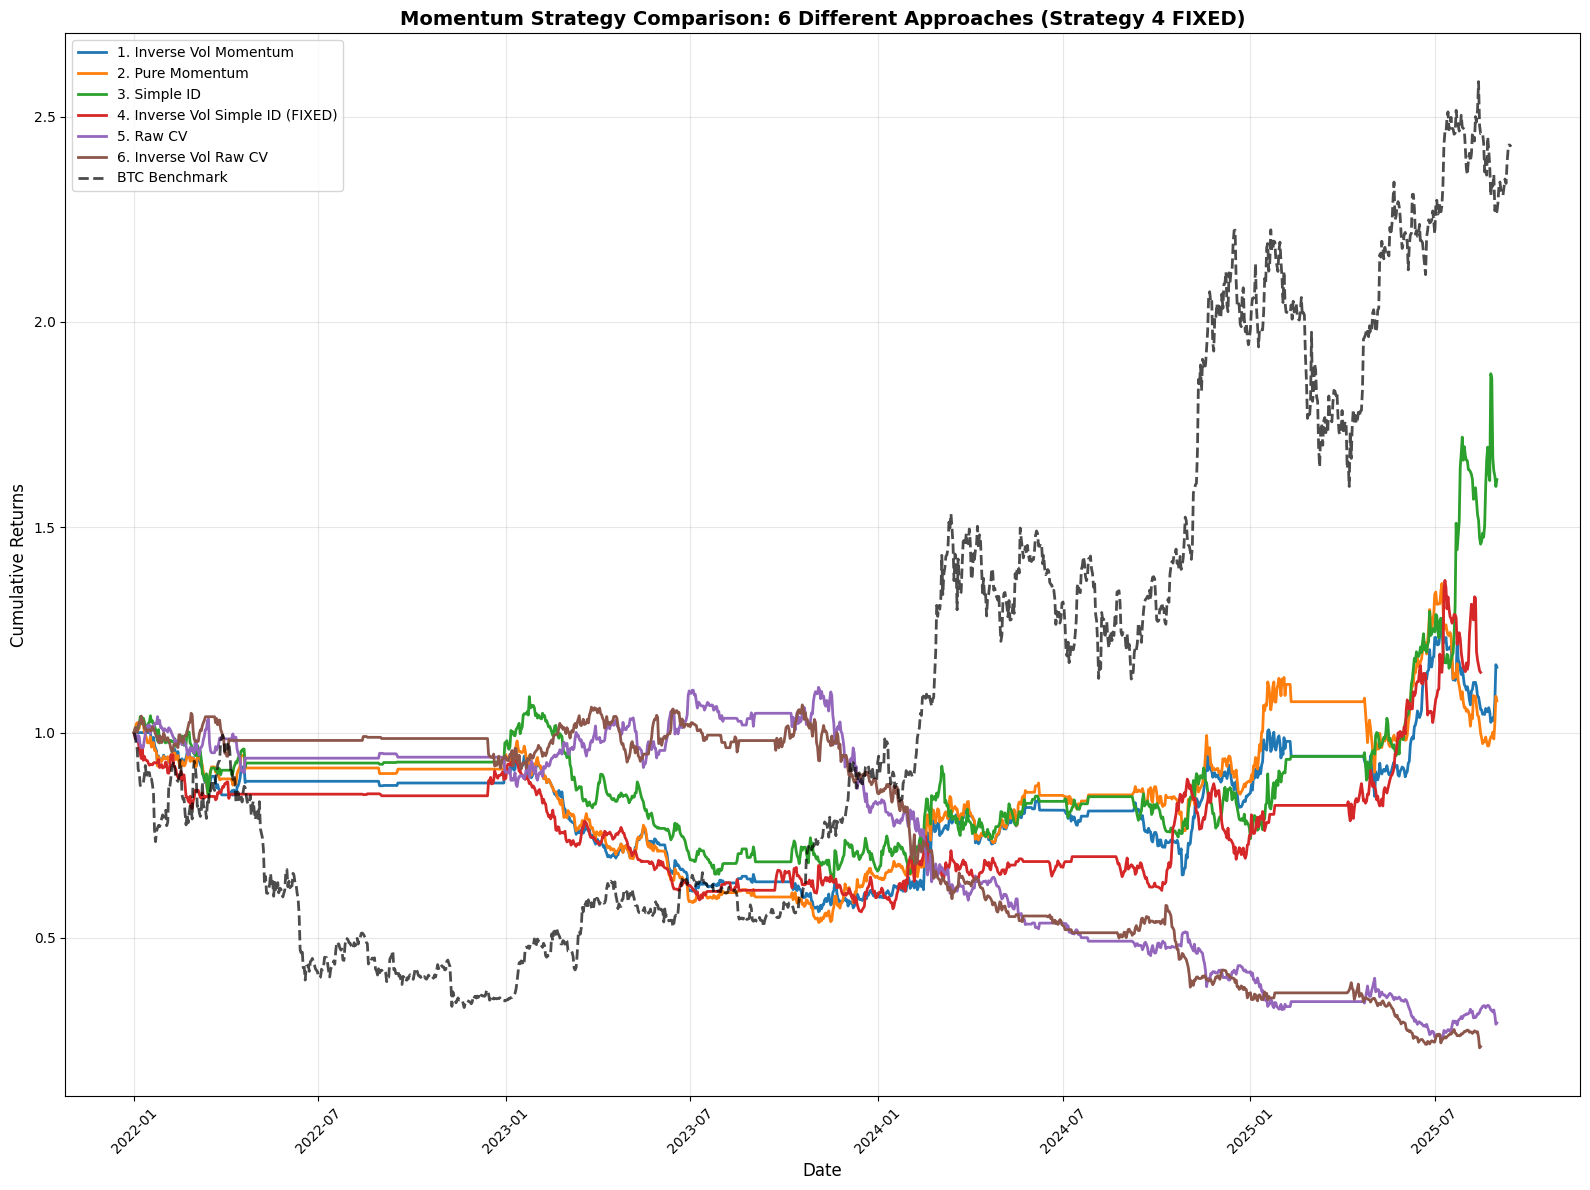


COMPREHENSIVE MOMENTUM STRATEGY PERFORMANCE COMPARISON (STRATEGY 4 FIXED)
                        Strategy Total Return Ann. Return Ann. Volatility Sharpe Ratio Max Drawdown Win Rate Final Value
         1. Inverse Vol Momentum        15.9%        4.1%           26.3%         0.16       -43.6%    31.0%        1.16
                2. Pure Momentum         7.7%        2.0%           27.4%         0.07       -47.8%    31.7%        1.08
                    3. Simple ID        61.6%       14.0%           31.6%         0.44       -41.4%    30.2%        1.62
4. Inverse Vol Simple ID (FIXED)        14.7%        3.9%           28.4%         0.14       -43.6%    29.2%        1.15
                       5. Raw CV       -70.7%      -28.4%           27.3%        -1.04       -77.3%    30.0%        0.29
           6. Inverse Vol Raw CV       -76.5%      -32.9%           26.4%        -1.25       -78.2%    29.3%        0.24
                   BTC Benchmark       143.2%       27.1%           52.4%     

In [9]:
# Create comparison plot with FIXED Strategy 4
plt.figure(figsize=(16, 12))

plt.plot(equity_1.index, equity_1.values, label="1. Inverse Vol Momentum", linewidth=2)
plt.plot(equity_2.index, equity_2.values, label="2. Pure Momentum", linewidth=2)
plt.plot(equity_3.index, equity_3.values, label="3. Simple ID", linewidth=2)
plt.plot(equity_4.index, equity_4.values, label="4. Inverse Vol Simple ID (FIXED)", linewidth=2)
plt.plot(equity_5.index, equity_5.values, label="5. Raw CV", linewidth=2)
plt.plot(equity_6.index, equity_6.values, label="6. Inverse Vol Raw CV", linewidth=2)
plt.plot(btc_cumret.index, btc_cumret.values, label="BTC Benchmark", linewidth=2, linestyle='--', alpha=0.7, color='black')

plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.title("Momentum Strategy Comparison: 6 Different Approaches (Strategy 4 FIXED)", fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate performance metrics with FIXED Strategy 4
def calculate_metrics(equity_series, name):
    """Calculate performance metrics for a strategy."""
    if not np.isfinite(equity_series).all():
        # Handle NaN/infinite values
        return {
            'Strategy': name,
            'Total Return': "NaN",
            'Ann. Return': "NaN", 
            'Ann. Volatility': "NaN",
            'Sharpe Ratio': "NaN",
            'Max Drawdown': "NaN",
            'Win Rate': "NaN",
            'Final Value': "NaN"
        }
    
    returns = equity_series.pct_change().dropna()
    total_return = (equity_series.iloc[-1] / equity_series.iloc[0]) - 1
    ann_return = (1 + total_return) ** (365 / len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(365)
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    
    # Calculate max drawdown
    peak = equity_series.cummax()
    drawdown = (equity_series / peak) - 1
    max_dd = drawdown.min()
    
    # Win rate
    win_rate = (returns > 0).mean()
    
    return {
        'Strategy': name,
        'Total Return': f"{total_return:.1%}",
        'Ann. Return': f"{ann_return:.1%}",
        'Ann. Volatility': f"{ann_vol:.1%}",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Max Drawdown': f"{max_dd:.1%}",
        'Win Rate': f"{win_rate:.1%}",
        'Final Value': f"{equity_series.iloc[-1]:.2f}"
    }

# Calculate metrics for all strategies (UPDATED)
metrics = []
metrics.append(calculate_metrics(equity_1, "1. Inverse Vol Momentum"))
metrics.append(calculate_metrics(equity_2, "2. Pure Momentum"))
metrics.append(calculate_metrics(equity_3, "3. Simple ID"))
metrics.append(calculate_metrics(equity_4, "4. Inverse Vol Simple ID (FIXED)"))
metrics.append(calculate_metrics(equity_5, "5. Raw CV"))
metrics.append(calculate_metrics(equity_6, "6. Inverse Vol Raw CV"))
metrics.append(calculate_metrics(btc_cumret, "BTC Benchmark"))

# Create performance table
df_metrics = pd.DataFrame(metrics)
print("\n" + "="*100)
print("COMPREHENSIVE MOMENTUM STRATEGY PERFORMANCE COMPARISON (STRATEGY 4 FIXED)")
print("="*100)
print(df_metrics.to_string(index=False))
print("="*100)

# Analysis insights
print("\nStrategy Descriptions:")
print("1. Inverse Vol Momentum: Original momentum ranking with inverse volatility weighting (Top 50 volume)")
print("2. Pure Momentum: Same momentum ranking with equal weighting (Top 50 volume)")
print("3. Simple ID: Information Discreteness + momentum with equal weighting (ALL assets)")
print("4. Inverse Vol Simple ID: Information Discreteness + momentum with inverse volatility weighting (ALL assets)")
print("5. Raw CV: Raw Coefficient of Variation + momentum with equal weighting (Top 50 volume)")
print("6. Inverse Vol Raw CV: Raw CV + momentum with inverse volatility weighting (Top 50 volume)")

print("\nKey Formulas:")
print("• Information Discreteness: ID = sign(PRET) × (% days negative – % days positive)")
print("• Raw CV: CV = std(price_changes) / mean(price_changes)")
print("• ID Combined Score: -ID × momentum (higher = better)")
print("• CV Combined Score: CV × momentum (lower = better)")

print("\nUniverse Selection:")
print("• Strategies 1,2,5,6: Top 50 assets by 20-day rolling volume")
print("• Strategies 3,4: ALL available assets (no volume filtering)")

print("\nCommon Parameters:")
print(f"• 14-day momentum/ID/CV windows, 10 long/10 short positions")
print(f"• {holding_period}-day holding period, BTC 90-day market filter, 5bps transaction costs")
print(f"• Inverse volatility weighting vs equal weighting comparison")
print(f"• Pure momentum vs Information Discreteness vs Raw CV comparison")

print("\nFIX APPLIED:")
print("• Strategy 4: Added proper NaN/zero volatility handling in inverse volatility calculations")
print("• Strategy 4: Added fallback to equal weights when volatility data is insufficient")
print("• Strategy 4: Added portfolio return validation to prevent NaN propagation")

RUNNING COMPREHENSIVE DAILY SIGNAL ANALYSIS
This analyzes signal quality on EVERY trading day, not just rebalance days
Calculating IC for 1-day, 7-day, and 14-day forward returns...


C:\Users\USER\AppData\Local\Temp\ipykernel_28656\1749988867.py:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  forward_returns[horizon] = price.pct_change(horizon).shift(-horizon)


Running DAILY signal analysis...


100%|██████████████████████████████████████████████████████████████████████████████| 1325/1325 [10:56<00:00,  2.02it/s]


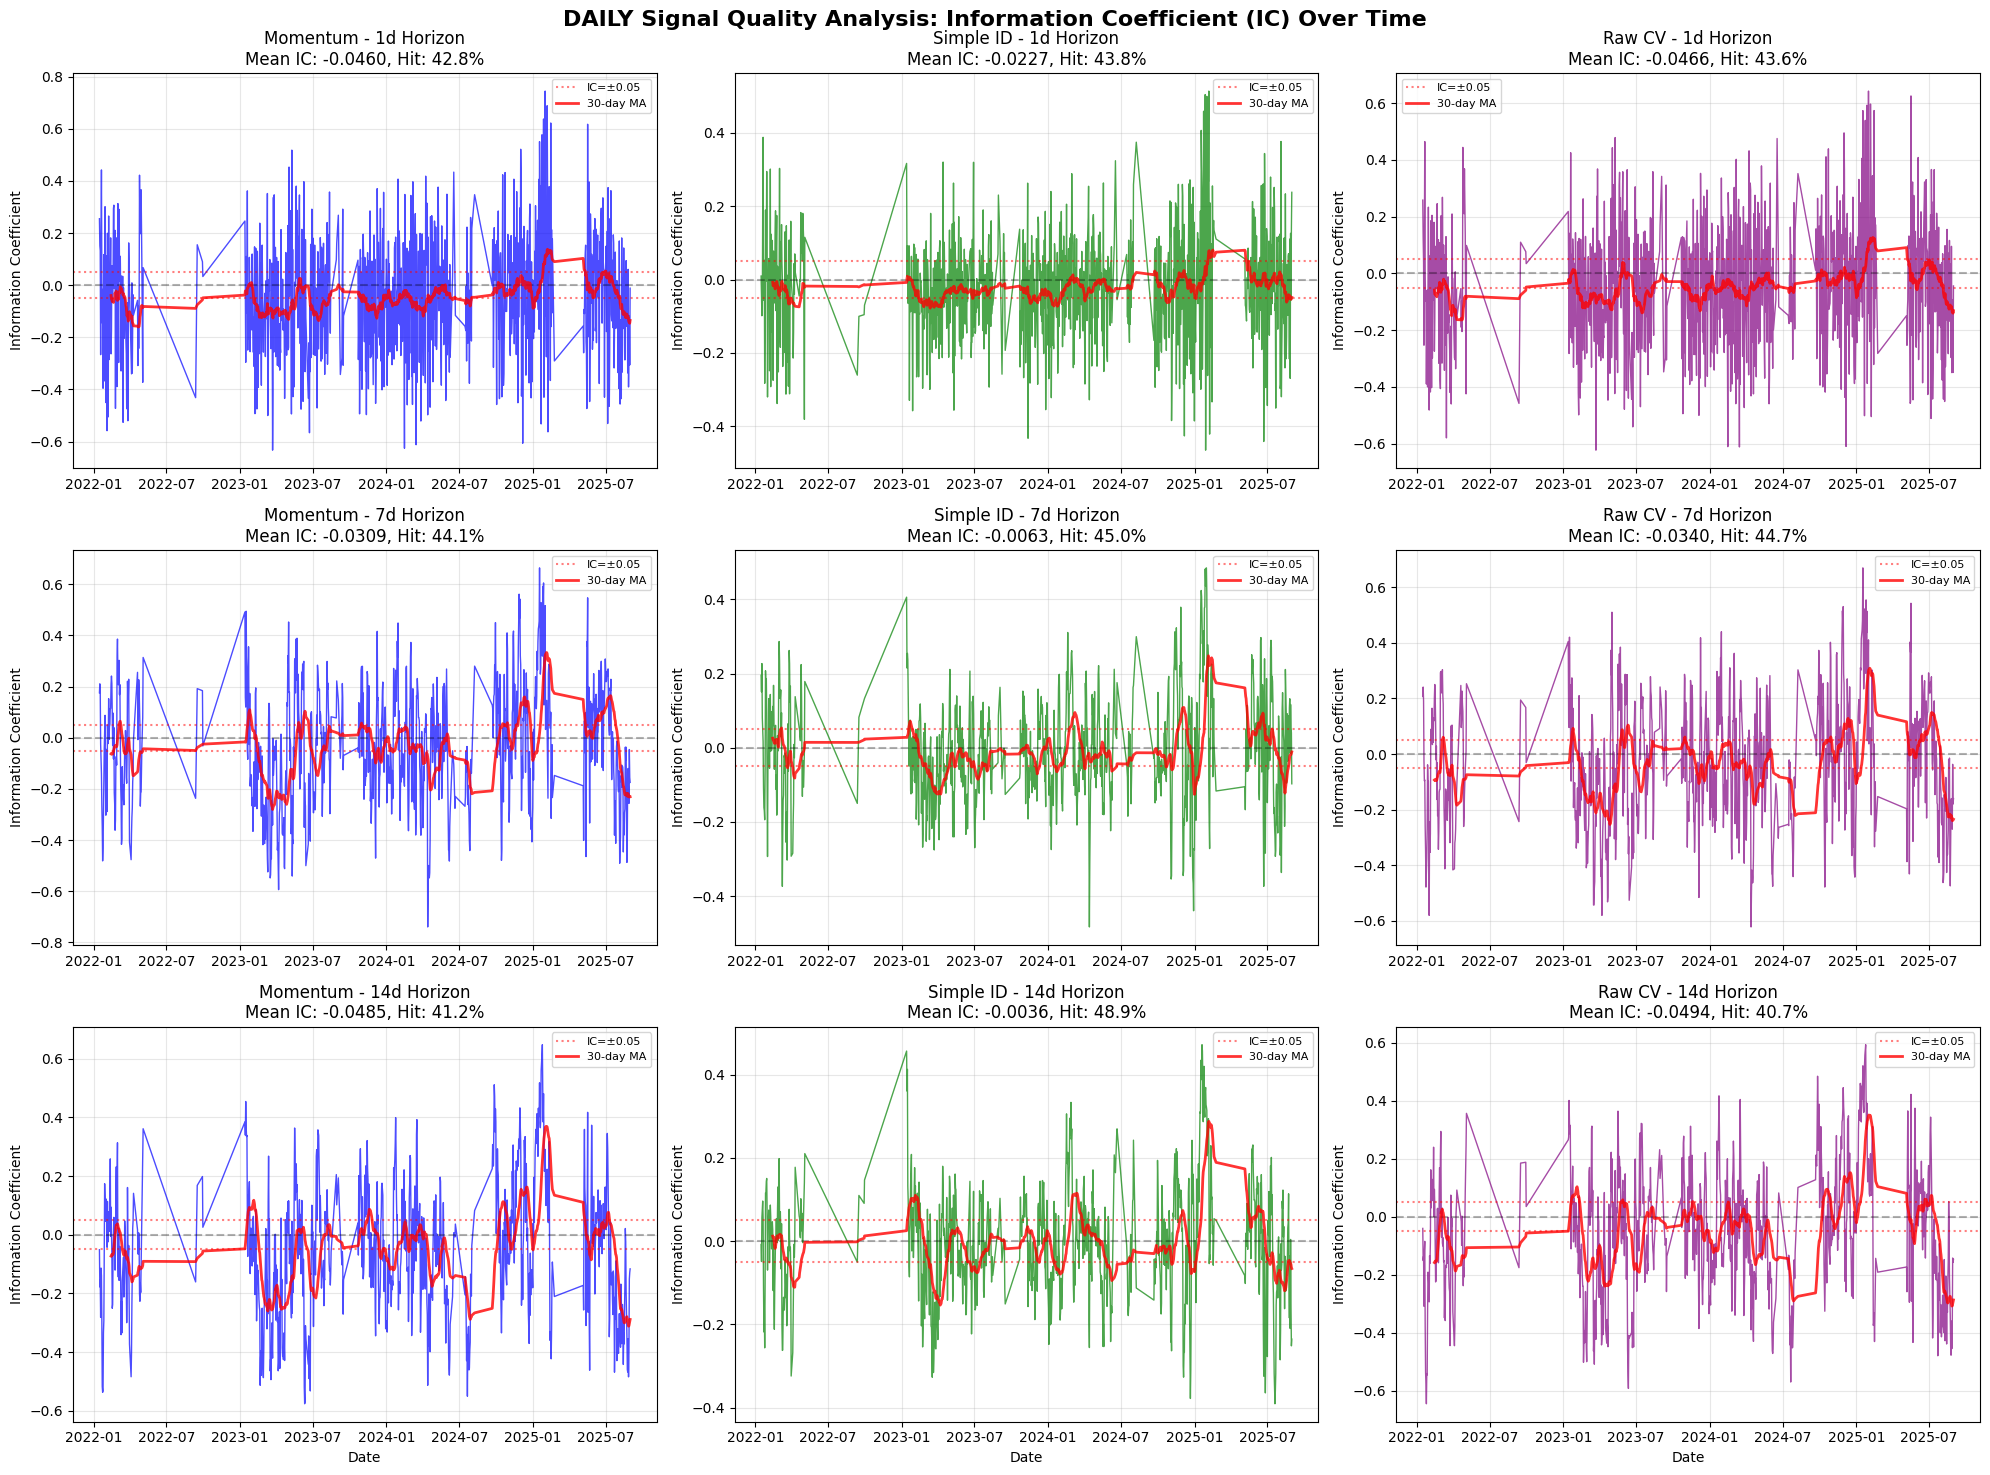

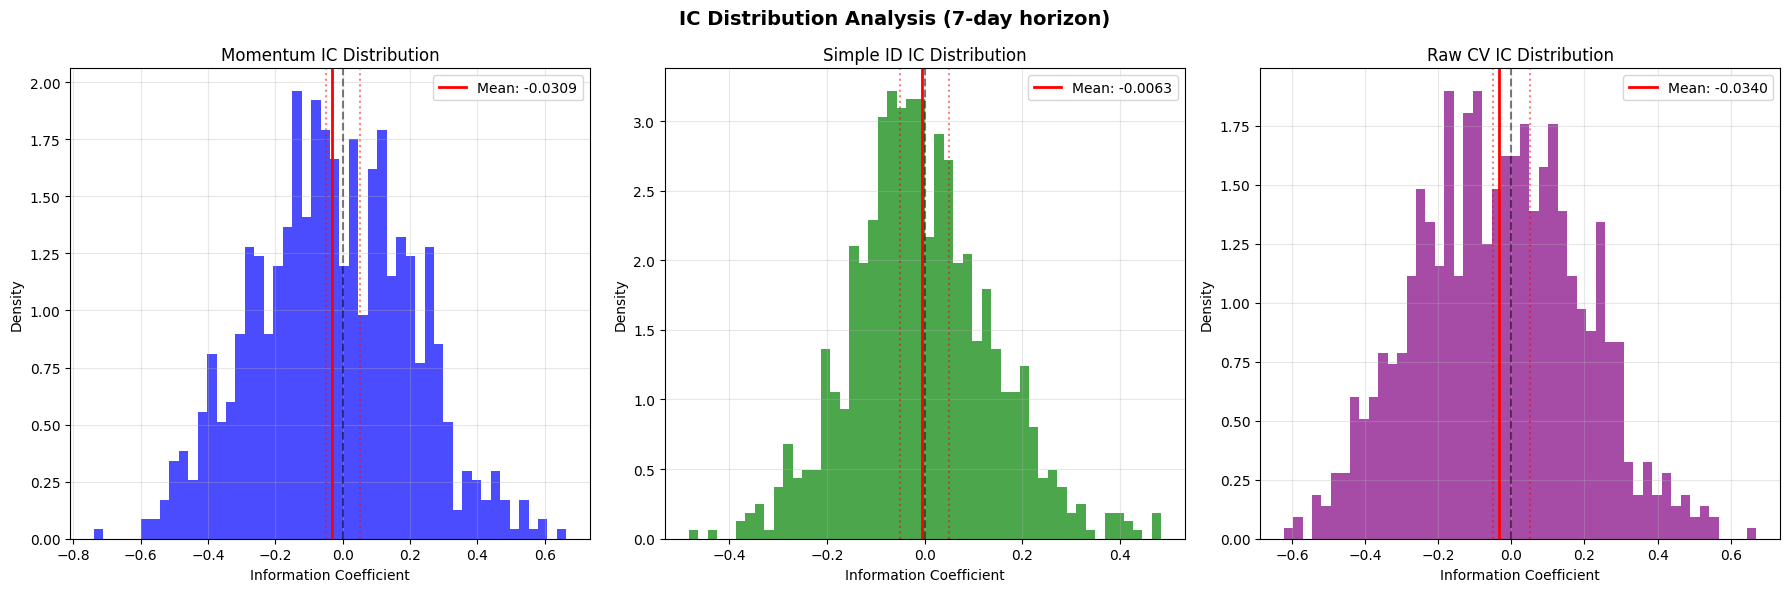


DAILY SIGNAL QUALITY ANALYSIS: INFORMATION COEFFICIENT METRICS
 Strategy Horizon Mean IC IC Std IC Sharpe Hit Rate Abs IC Observations
 Momentum      1d -0.0460 0.2307     -0.20    42.8% 0.1891          835
Simple ID      1d -0.0227 0.1479     -0.15    43.8% 0.1161          835
   Raw CV      1d -0.0466 0.2219     -0.21    43.6% 0.1835          835
 Momentum      7d -0.0309 0.2291     -0.13    44.1% 0.1880          835
Simple ID      7d -0.0063 0.1438     -0.04    45.0% 0.1124          835
   Raw CV      7d -0.0340 0.2221     -0.15    44.7% 0.1833          835
 Momentum     14d -0.0485 0.2182     -0.22    41.2% 0.1779          835
Simple ID     14d -0.0036 0.1347     -0.03    48.9% 0.1028          835
   Raw CV     14d -0.0494 0.2156     -0.23    40.7% 0.1757          835

Interpretation:
• Mean IC > 0: Signal positively predicts returns
• |IC| > 0.05: Generally considered meaningful in practice
• IC Sharpe: Risk-adjusted signal quality (Mean IC / IC Std)
• Hit Rate: % of periods with

In [10]:
# Run DAILY signal analysis
print("="*80)
print("RUNNING COMPREHENSIVE DAILY SIGNAL ANALYSIS")
print("="*80)
print("This analyzes signal quality on EVERY trading day, not just rebalance days")
print("Calculating IC for 1-day, 7-day, and 14-day forward returns...")

daily_signal_results = run_daily_signal_analysis()

# Plot daily signal analysis
plot_daily_signal_analysis(daily_signal_results)

# Strategy-specific insights
print("\n" + "="*80)
print("DAILY SIGNAL ANALYSIS INSIGHTS")
print("="*80)

print("\nSignal Quality Ranking (by IC Sharpe, 7-day horizon):")
strategies_ranked = sorted(['momentum', 'id', 'cv'], 
                          key=lambda x: daily_signal_results[7][x]['metrics']['ic_sharpe'], 
                          reverse=True)

for rank, strategy in enumerate(strategies_ranked, 1):
    name = {'momentum': 'Momentum', 'id': 'Simple ID', 'cv': 'Raw CV'}[strategy]
    metrics = daily_signal_results[7][strategy]['metrics']
    print(f"{rank}. {name:12}: IC Sharpe = {metrics['ic_sharpe']:+.2f}, "
          f"Mean IC = {metrics['mean_ic']:+.4f}, "
          f"Hit Rate = {metrics['hit_rate']:.1%}")

print(f"\nDaily vs Strategy Performance Insights:")
print(f"• High IC Sharpe indicates consistent predictive power")
print(f"• Hit Rate > 50% means signal is correct more often than not") 
print(f"• Compare signal quality ranking with strategy performance ranking")
print(f"• Daily analysis reveals signal degradation periods")
print(f"\nCOMPARE SIGNAL ANALYSIS RESULTS WITH STRATEGY PERFORMANCE BELOW:")